## Data

Release: Advance Monthly Sales for Retail and Food Services  
Units:  Millions of Dollars, Not Seasonally Adjusted

Frequency:  Monthly

The value for the most recent month is an advance estimate that is based on data from a subsample of firms from the larger Monthly Retail Trade Survey. The advance estimate will be superseded in following months by revised estimates derived from the larger Monthly Retail Trade Survey. The associated series from the Monthly Retail Trade Survey is available at https://fred.stlouisfed.org/series/MRTSSM448USN

Information about the Advance Monthly Retail Sales Survey can be found on the Census website at https://www.census.gov/retail/marts/about_the_surveys.html

Suggested Citation:
U.S. Census Bureau, Advance Retail Sales: Clothing and Clothing Accessory Stores [RSCCASN], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/RSCCASN, November 16, 2019.

https://fred.stlouisfed.org/series/RSCCASN

In [1]:
## Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# load data and check
df = pd.read_csv('RSCCASN.csv')
df.head()

,DATE,RSCCASN
0,1992-01-01,6938
1,1992-02-01,7524
2,1992-03-01,8475
3,1992-04-01,9401
4,1992-05-01,9558


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334 entries, 0 to 333
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   DATE     334 non-null    object
 1   RSCCASN  334 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 5.3+ KB


- We would want the date column to be date_time type
- Also, make it as index

In [5]:
# read the data again ana parse dates
df = pd.read_csv('RSCCASN.csv', parse_dates=True, index_col='DATE')
df.head()

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 334 entries, 1992-01-01 to 2019-10-01
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   RSCCASN  334 non-null    int64
dtypes: int64(1)
memory usage: 5.2 KB


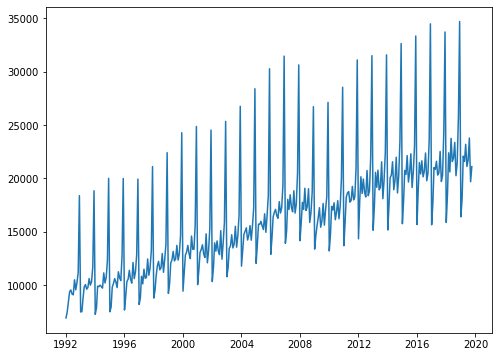

In [9]:
# plot and check
plt.figure(figsize=(8,6))
plt.plot(df)
plt.show()

## Split the data into train and test

In [11]:
# lets check the data first
df.head(5)

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [12]:
df.tail(5)

,RSCCASN
DATE,
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791
2019-09-01,19695
2019-10-01,21113


In [13]:
# length of our data 
len(df)

334

- we can see the data is in monthly format
- I would like to forecast around 1.5 years, i.e. 18 months

In [15]:
# get the test data index values
len(df) - 18

316

In [16]:
# set the train and test data
train = df.iloc[:316]
test = df.iloc[316:]

len(train), len(test)

(316, 18)

In [17]:
train.head(3)

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475


In [19]:
test.tail(3)

,RSCCASN
DATE,
2019-08-01,23791
2019-09-01,19695
2019-10-01,21113


## Pre-Processing the data

In [20]:
# import scaler
from sklearn.preprocessing import MinMaxScaler

In [21]:
# scale and transform data
scaler = MinMaxScaler()

In [22]:
scaler.fit(train)

train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)

## Create model

In [23]:
# import libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

### Create timeseries generator for train and validation

In [24]:
# lets get the shape of our data
train.shape

(316, 1)

- I would keep the length of our batch_size = 12 since we have 18 samples in our validation dataset

In [25]:
length = 12
# train data generator
train_generator = TimeseriesGenerator(train_scaled,
                                      train_scaled,
                                      length=length,
                                      batch_size=1)

# test data generator
test_generator = TimeseriesGenerator(test_scaled,
                                      test_scaled,
                                      length=length,
                                      batch_size=1)

In [26]:
# check generator 
train_generator[0]

(array([[[0.        ],
         [0.02127505],
         [0.05580163],
         [0.08942056],
         [0.09512053],
         [0.08146965],
         [0.07860151],
         [0.12979233],
         [0.09566512],
         [0.1203892 ],
         [0.15426227],
         [0.41595266]]]),
 array([[0.02047633]]))

In [27]:
# no. of features
n_features = 1

In [37]:
# initialize and define the model
model = Sequential()

# add LSTM
model.add(LSTM(100,activation = 'relu',input_shape=(length,n_features)))

# add Dense layer for output
model.add(Dense(1))

# compile the model
model.compile(optimizer='adam', loss='mse')

In [38]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 100)               40800     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [34]:
# define early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=2)

In [39]:
# fit the model
model.fit_generator(train_generator,
                    epochs=20,
                    validation_data=test_generator,
                    callbacks=[early_stop]
                   )

Epoch 1/20


C:\Users\budha\AppData\Local\Temp\ipykernel_2076\609219731.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_generator,


304/304 [==============================] - 3s 5ms/step - loss: 0.0229 - val_loss: 0.0083
Epoch 2/20
304/304 [==============================] - 1s 5ms/step - loss: 0.0185 - val_loss: 0.0031
Epoch 3/20
304/304 [==============================] - 1s 4ms/step - loss: 0.0099 - val_loss: 0.0016
Epoch 4/20
304/304 [==============================] - 1s 5ms/step - loss: 0.0069 - val_loss: 0.0111
Epoch 5/20
304/304 [==============================] - 2s 6ms/step - loss: 0.0027 - val_loss: 2.4378e-04
Epoch 6/20
304/304 [==============================] - 3s 9ms/step - loss: 0.0018 - val_loss: 0.0054
Epoch 7/20
304/304 [==============================] - 1s 5ms/step - loss: 0.0014 - val_loss: 0.0026


<AxesSubplot:>

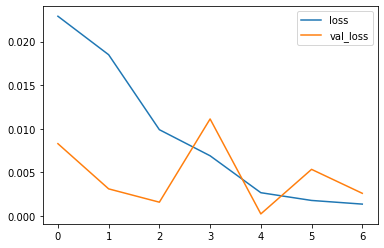

In [40]:
pd.DataFrame(model.history.history).plot()

## Evaluate the model performance

In [45]:
# intialize to store the test prediction values
test_predictions = []

# initialize the first evaluation batch 
# this is the last 12 samples in the train set
# this will be used to predict the first test data i.e. test_scaled[0]
first_eval_batch = train_scaled[-length:]
current_batch = first_eval_batch.reshape(1, length, n_features)

for i in range(len(test_scaled)):
    
    # predict using the current batch
    prediction = model.predict(current_batch)[0]
    
    # append the result in test_predictions list
    test_predictions.append(prediction)
    
    # update the current batch value
    # remove the very first element in the current batch
    # add the new pred value at the end of current batch
    # this will be again use to predict the next element in the test set
    current_batch = np.append(current_batch[:,1:,:], [[prediction]], axis = 1)

1/1 [==============================] - 0s 19ms/step


In [46]:
# this test_prediction is in scaled format
# we will need to rescale it back to its original format
test_predictions

[array([0.47001123], dtype=float32),
 array([0.43795088], dtype=float32),
 array([0.44442153], dtype=float32),
 array([0.49791098], dtype=float32),
 array([0.42560214], dtype=float32),
 array([0.44283074], dtype=float32),
 array([0.5627201], dtype=float32),
 array([0.8350022], dtype=float32),
 array([0.31293383], dtype=float32),
 array([0.3799011], dtype=float32),
 array([0.48489034], dtype=float32),
 array([0.43457028], dtype=float32),
 array([0.41631186], dtype=float32),
 array([0.39510077], dtype=float32),
 array([0.40005845], dtype=float32),
 array([0.43770203], dtype=float32),
 array([0.3885467], dtype=float32),
 array([0.40167746], dtype=float32)]

In [47]:
# rescaling back
true_predictions = scaler.inverse_transform(test_predictions)
true_predictions

array([[19883.9894371 ],
       [19000.91902041],
       [19179.14661598],
       [20652.45993423],
       [18660.78529024],
       [19135.32994127],
       [22437.56298399],
       [29937.30015373],
       [15557.44947982],
       [17401.99620485],
       [20293.8195734 ],
       [18907.80386662],
       [18404.89387417],
       [17820.65567446],
       [17957.20990038],
       [18994.06471276],
       [17640.1304493 ],
       [18001.80394387]])

In [49]:
## now we can add to our test data and compare the predicted values with the original true values
test['Predictions'] = true_predictions
test.head()

C:\Users\budha\AppData\Local\Temp\ipykernel_2076\887938323.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


,RSCCASN,Predictions
DATE,,
2018-05-01,23764,19883.989437
2018-06-01,21589,19000.919020
2018-07-01,21919,19179.146616
2018-08-01,23381,20652.459934
2018-09-01,20260,18660.785290


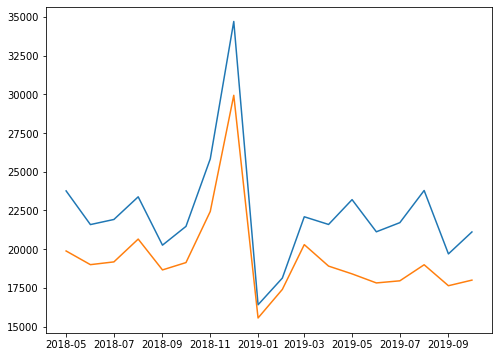

In [51]:
# plot and compare
plt.figure(figsize=(8,6))
plt.plot(test)
plt.show();

## Forecast

In [52]:
# first we will need to train our model on full data
full_scaler = MinMaxScaler()

In [53]:
data_scaled = full_scaler.fit_transform(df)

In [54]:
# create generator
generator = TimeseriesGenerator(data_scaled,data_scaled,length=length,batch_size=1)

In [69]:
# create model 
final_model = Sequential()

# add LSTM
final_model.add(LSTM(100,activation='relu',input_shape=(length,n_features)))

# add Dense for output
final_model.add(Dense(1))

# compile
final_model.compile(optimizer='adam', loss='mse')

In [70]:
# fit model
final_model.fit_generator(generator,epochs=6)

Epoch 1/6


C:\Users\budha\AppData\Local\Temp\ipykernel_2076\3285806281.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  final_model.fit_generator(generator,epochs=6)


322/322 [==============================] - 3s 6ms/step - loss: 0.0250
Epoch 2/6
322/322 [==============================] - 2s 6ms/step - loss: 0.0174
Epoch 3/6
322/322 [==============================] - 2s 5ms/step - loss: 0.0094
Epoch 4/6
322/322 [==============================] - 2s 6ms/step - loss: 0.0046
Epoch 5/6
322/322 [==============================] - 2s 5ms/step - loss: 0.0028
Epoch 6/6
322/322 [==============================] - 2s 5ms/step - loss: 0.0016


In [71]:
# forecasting predictions for next 12 months

# intialize to store the forecast values
forecast = []

# initialize the first evaluation batch 
# this is the last 12 samples in the train set
# this will be used to predict the first test data i.e. test_scaled[0]
first_eval_batch = data_scaled[-12:]
current_batch = first_eval_batch.reshape(1, length, n_features)

for i in range(12):
    
    # predict using the current batch
    prediction = final_model.predict(current_batch)[0]
    
    # append the result in test_predictions list
    forecast.append(prediction)
    
    # update the current batch value
    # remove the very first element in the current batch
    # add the new pred value at the end of current batch
    # this will be again use to predict the next element in the test set
    current_batch = np.append(current_batch[:,1:,:], [[prediction]], axis = 1)

1/1 [==============================] - 0s 30ms/step


In [72]:
# rescaling it back to original format
forecast = full_scaler.inverse_transform(forecast)

In [60]:
df.tail()

,RSCCASN
DATE,
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791
2019-09-01,19695
2019-10-01,21113


In [73]:
# now creating index for forecast values
# using pandas, starting from 2019-11-01 as we can see the last entry in our train data is 2019-10-01
# fre='MS' : means Month Start Frequency
# can see all available freq values at : 
# https://stackoverflow.com/questions/35339139/what-values-are-valid-in-pandas-freq-tags
forecast_index = pd.date_range(start='2019-11-01', periods=12, freq='MS')
forecast_index

DatetimeIndex(['2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01'],
              dtype='datetime64[ns]', freq='MS')

In [74]:
# create dataFrame
#forecast_df
forecast_df = pd.DataFrame(data=forecast, index=forecast_index, columns=['predictions'])
forecast_df

,predictions
2019-11-01,25292.499412
2019-12-01,35089.228886
2020-01-01,16890.494412
2020-02-01,18022.684988
2020-03-01,21257.553273
2020-04-01,20842.359407
2020-05-01,22329.994675
2020-06-01,20527.181686
2020-07-01,21024.036619
2020-08-01,22926.816100


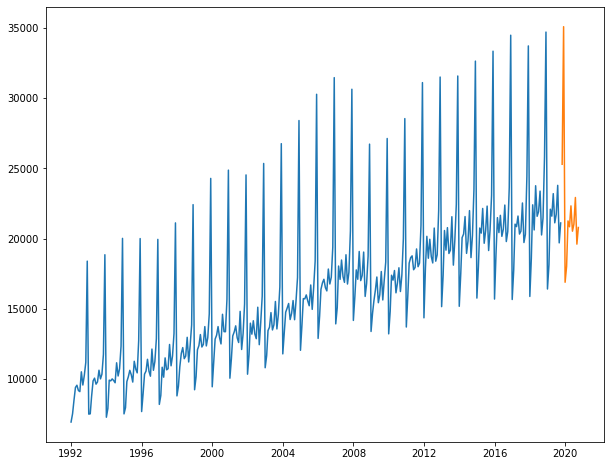

In [80]:
# plot and check with the original data

plt.figure(figsize=(10,8))
ax = plt.plot(df)
plt.plot(forecast_df)
plt.show()

(576.0, 611.0)

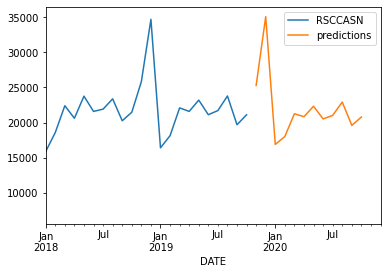

In [78]:
ax = df.plot()
forecast_df.plot(ax=ax)
plt.xlim('2018-01-01','2020-12-01')